In [71]:
# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'widget')

import math
import cmath
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk 
from tkinter import filedialog

## Fuel Grain Mass and Area

In [72]:
def fuel_effective_grain_area(r):
    return math.pi * r**2 # A = pi*r^2

In [73]:
def fuel_mass(r, h):
    paraffin_d = 900; # kg/m3\n",
    return (math.pi * r**2 * h) * paraffin_d # pi*r^2*h*paraffin density"

## Reading Files
Reads NASA CEA data formatted into four .txt files. Outputs used: T, K; MW, (1/n); GAMMAs; P, BAR

In [74]:
def read_files():
    
    # OF temps
    print("Select temps file: ")
    Tdata = filedialog.askopenfilename()
    print("Selected file path: ", Tdata)
    with open(Tdata, 'r') as file:
        T_array = [float(line.strip()) for line in file.readlines()]
    
    # Molar mass of exhaust gases
    print("Select Molar Mass file: ")
    Mdata = filedialog.askopenfilename()
    print("Selected file path: ", Mdata)
    with open(Mdata, 'r') as file:
        M_array = [float(line.strip()) for line in file.readlines()]
    
    # Gamma
    print("Select Gamma file: ")
    Gdata = filedialog.askopenfilename()
    print("Selected file path: ", Gdata)
    with open(Gdata, 'r') as file:
        G_array = [float(line.strip()) for line in file.readlines()]

    # Chamber Pressures
    print("Select Chamber Pressures file: ")
    PcData = filedialog.askopenfilename()
    print("Selected file path: ", PcData)
    with open(PcData, 'r') as file:
        Pc_array = [float(line.strip()) for line in file.readlines()]

    return T_array, M_array, G_array, Pc_array

## Solving for Pe using the Newton-Raphson method

In [75]:
def Pe(E, gm1, pr, g, gp1, gm1g):
    # Calculate the exit pressure ratio from the given formula
    return 1.0 / E - ((gp1 / 2.0)**(1.0 / gm1)) * (pr**(1.0 / g)) * cmath.sqrt((gp1 / gm1) * (1.0 - (pr ** gm1g)))

In [76]:
def dPe(E, gm1, pr, g, gp1, gm1g):
# Calculate the numerical approximation of the derivative of the exit pressure ratio with respect to pressure ratio
    
    # step size for numerical approximation
    step = 10**-8
    
    # approximates the slope of the function at the point (pr, Pe(pr))
    numerator = Pe(E, gm1, pr + step, g, gp1, gm1g) - Pe(E, gm1, pr, g, gp1, gm1g) 
    denominator = step
    
    # if the denominator = 0, set it to a small value
    if abs(denominator) < 1e-10:
        denominator = 1e-10
    
    return numerator / denominator

In [77]:
def pratio(kappa, E):
    
    gm1 = kappa - 1.0
    gp1 = kappa + 1.0
    gm1g = gm1 / kappa
    g = kappa

    # Set initial conditions
    pr0 = 0.001 # Initial guess for the pressure ratio
    Err = 0.1 # Initial error
    pr = 0.0 # Initial pressure ratio

    # Iterate until the desired accuracy is achieved
    i = 0
    while Err > 0.0001:
        # Calculate the pressure ratio using Newton-Raphson method
        pr = pr0 - Pe(E, gm1, pr0, g, gp1, gm1g) / dPe(E, gm1, pr0, g, gp1, gm1g) # Newton-Raphson method: x(n+1) = x(n) - f(x(n))/f'(x(n))
        Err = abs((pr - pr0) / pr0) 
        pr0 = pr 
        i += 1

    # print("Solution of nonlinear equation for Pressure ratio:", pr, "after", i, "iterations")
    return pr

## Hybrid Rocket Thrust

In [78]:
def hybrid_rocket_thrust(r, h, T_array, M_array, G_array, Pc_array):
    
    # Fuel Mass
    m_f = fuel_mass(r, h)

    R = 8.3144598 # J/mol*K
    
    # Molecular Weights
    MW_fuel = 352     # g/mol, molecular weight of fuel (paraffin)
    MW_oxidizer = 32     # g/mol, molecular weight of oxidizer (O2)
    
    # Oxidizer Flow Rate (O2)
    m_o = 0.01429
    
    # Mass flux oxidizer (total)
    j_m = (m_o)/(math.pi * r**2) 
    
    # Regression rate 
    rdot = 0.304 * j_m**0.527

    # Area of the fuel grain
    A_f = fuel_effective_grain_area(r)
    
    # Fuel Mass Flow Rate
    mdot_f = 900 * A_f * rdot 
    
    # Mass Flow Rate
    mdot_total = m_o + mdot_f 

    # Oxidizer to Fuel Ratio
    OF_ratio = m_o/m_f
    
    for t in T_array:
        for m in M_array:
            for k in G_array:
                for Pc in Pc_array:
                    
                    # Convert Bar to Pa
                    Pc_Pa = Pc * 100000 

                    # Area of the throat
                    A_t = mdot_total/Pc_Pa * math.sqrt(8.314*t/(k*2/(k+1))**((k+1)/(k-1))) # from rocket propulsion elements fig 3-5
                    
                    # Calculating the mass fraction of paraffin and o2
                    m_frac_paraffin = MW_fuel / (MW_fuel + MW_oxidizer)
                    m_frac_o2 = MW_oxidizer / (MW_oxidizer + MW_fuel)

                    # Calculating average molecular weight
                    ave_mol_wt = (m_frac_paraffin * MW_fuel) + (m_frac_o2 * MW_oxidizer)

                    # Using the ideal gas law to find the density of the mixture
                    rho_mixture = (Pc_Pa * ave_mol_wt) / (8.314 * t)
                    rho_oxidizer = (Pc_Pa * MW_oxidizer) / (8.314 * t)

                    # Area of the throat: Based on isentropic relations, assumes flow is choked
                    A_t = mdot_total/Pc_Pa * math.sqrt(8.314*t/(k*2/(k+1))**((k+1)/(k-1))) # from rocket propulsion elements fig 3-5
                    
                    # Flow velocity: V = m_dot / (rho * A)
                    V = m_o * (rho_mixture * A_t)

                    # Speed of sound
                    a = math.sqrt(k*8.314*t)

                    # Mach Number
                    M = V/a
                    
                    # Expansion Ratio, from rocket propulsion elements example 3-1 (implies no losses)
                    E = (1/M)*((1+((k-1/2)*M**2))/(k+1/2))**((k+1)/(2*(k-1)))

                    # Exit Pressure Ratio
                    Pe = pratio(k, E)
                    
                    # Calculate the exit velocity
                    v_e = np.sqrt((t*8.3144598)/m)*np.sqrt((2*k/k-1))*(1-(Pe/Pc_Pa)**((k-1)/k))

                    # Calculate the rocket thrust
                    thrust = (m_o + m_f) * v_e

    # Return the calculated thrust
    return thrust

## Thrust with different fuel grain sizes

In [79]:
def plotThrust(r, h, thrust, T_array, M_array, G_array, Pc_array):
    
    plt.figure()
    
    radii = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]  # fuel grain radii  m
    heights = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # fuel grain heights  m
    
    volArr = np.array([])
    thrustArr = np.array([])
    
    for r in radii:
        for h in heights:
            # Put data into arrays
            thrust = hybrid_rocket_thrust(r, h, T_array, M_array, G_array, Pc_array)
            volume = np.pi*r**2*h
            
            thrustArr = np.append(thrustArr, [thrust]) 
            volArr = np.append(volArr, [volume]) 
    
    # Plotting the points
    
    plt.plot(thrustArr, volArr, marker='.', linestyle='-', color='tab:pink', label='1')
    
    plt.xlabel('Thrust (N)')
    plt.ylabel('Volume of Fuel Grain (m^3)')
  
    plt.title('Hybrid Rocket Thrust')
    
    
    plt.show()

Select temps file: 
Selected file path:  C:/Users/JazzyBee/Desktop/Data/OF_temps.txt
Select Molar Mass file: 
Selected file path:  C:/Users/JazzyBee/Desktop/Data/Molar_Masses.txt
Select Gamma file: 
Selected file path:  C:/Users/JazzyBee/Desktop/Data/Gammas.txt
Select Chamber Pressures file: 
Selected file path:  C:/Users/JazzyBee/Desktop/Data/Chamber_Pressures.txt
Top 5 Thrust Values
Radius = 0.1, Height = 1.0, Thrust = 657.94 N (2dp)
Radius = 0.1, Height = 0.9, Thrust = 592.18 N (2dp)
Radius = 0.09, Height = 1.0, Thrust = 534.5 N (2dp)
Radius = 0.1, Height = 0.8, Thrust = 526.42 N (2dp)
Radius = 0.09, Height = 0.9, Thrust = 481.09 N (2dp)


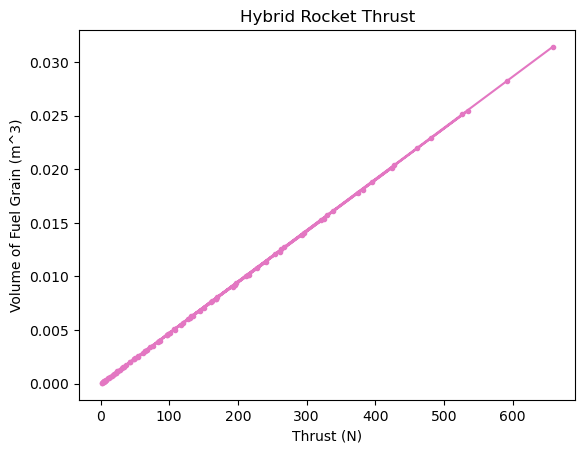

In [80]:
# different fuel grain sizes
radii = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]  # fuel grain radii  m
heights = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # fuel grain heights  m

# Initialise data
T_array, M_array, G_array, Pc_array = read_files()

thrust_values = []

for r in radii:
    for h in heights:
        
        # Calculate the thrust
        thrust = hybrid_rocket_thrust(r, h, T_array, M_array, G_array, Pc_array)
        thrust_values.append((r, h, thrust))  # store the radius, height, and thrust values in the list
       
        volume = np.pi*r**2*h
        mass = volume*900
        
        # Calculate the thrust to mass ratio
        t2 = (thrust/10)/mass
        
        # print("Radius = ", r, "Height = ", h, "Thrust = ", thrust2dp, "N (2dp)", "mass = ",  mass, "t2 = ", t2.real)

# Sort the thrust values in descending order and print the top 5
sorted_thrust_values = sorted(thrust_values, key=lambda x: x[2].real, reverse=True)

print("Top 5 Thrust Values")

for i in range(5):
    r, h, thrust = sorted_thrust_values[i]
    thrust2dp = round(thrust.real, 2)
    print(f"Radius = {r}, Height = {h}, Thrust = {thrust2dp} N (2dp)")

plotThrust(radii, heights, thrust, T_array, M_array, G_array, Pc_array)